## Run this notebook in Google Colab by clicking here: [Google Colab](https://colab.research.google.com/github/AaronDJohnson/12p5yr_stochastic_analysis/blob/master/tutorials/explore_data.ipynb)

### Run these cells if using Colab. Otherwise, skip them!

In [ ]:
# This cell will reset the kernel.
# Run this cell, wait until it's done, then run the next.
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

In [ ]:
%%capture
!mamba install -y -c conda-forge enterprise_extensions la_forge
!git clone https://github.com/AaronDJohnson/12pyr_stochastic_analysis
import sys
sys.path.insert(0,'/content/15yr_stochastic_analysis/tutorials')

# Exploring NANOGrav Data

  * In this tutorial, you will learn what information exists in the data used by the NANOGrav data working group to search for gravitational waves with pulsar timing data.

  * The next two cells import Python packages that we will use to load and look at the data and set the data directory according to whether you are using Google Colab or something else.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, json
from enterprise import pulsar
from settings import load_pulsars

import sys
IN_COLAB = 'google.colab' in sys.modules

In [2]:
if IN_COLAB:
    datadir = '/content/12p5yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

## Pulsar timing data
  `TEMPO`, `TEMPO2` and `PINT` are packages written in various programming languages to enable pulsar timing.

  These packages require:
  * Clock files that contain corrections necessary for accurate timing
  * Files that contain information about the orientation of Earth at each pulse time
  * An ephemeris to show the location and movement of solar system objects
  * Location of observatories where radio telescopes exist to record pulse times of arrival (TOAs)
  

### `.tim` files

`.tim` files contain the pulse TOAs.

Let's look at an example of a TOA

In [ ]:
# FORMAT 1
# 53358.000051.3.000.000.9y.x.ff 1442.000000 53358.727464829165176   0.382   ao  -fe L-wide -be ASP -f L-wide_ASP -bw 4 -tobs 903.76 -tmplt B1855+09.L-wide.PUPPI.9y.x.sum.sm -gof 1.02 -nbin 2048 -nch 1 -chan 0 -subint 0 -snr 468.67 -wt 15 -proc 9y -pta NANOGrav -to -0.839e-6

There are a few things to notice here:
* `FORMAT 1` is a TEMPO2 style format for the `.tim` file

The next line is several bits of information separated by spaces
* File name or identifier
* Observing frequency (MHz)
* Pulse site arrival time (MJD)
* Uncertainty on arrival time (microseconds)
* Observing site

The rest of the pieces are flags that denote receiver and backend, SNR, and other information that might be useful.

If a line starts with a `C`, it has been commented and therefore removed from the used data (perhaps as an outlier or of poor data quality)

### `.par` files
  `.par` files contain parameters that specify the best fit parameters for the timing model. In order to count the number of pulsar rotations, we need to have an accurate measure of the pulsar's spin, spin-down, position, motion on the sky, binary orbital parameters and so on. These parameters are stored in the `.par` files.

  For example, let's look at a few lines from `B1855+09_NANOGrav_12yv3.gls.par`


In [ ]:
# PSR              B1855+09
# LAMBDA   286.8634874759636  1     0.0000000120871
# BETA      32.3214851773070  1     0.0000000190648
# PMLAMBDA           -3.2685  1              0.0092
# PMBETA             -5.0604  1              0.0176
# PX                  0.7149  1              0.1217
# POSEPOCH        55637.0000
# F0    186.4940812354548996  1  0.0000000000047889
# F1     -6.204791865029D-16  1  2.855227959554D-20
# PEPOCH        55637.000000
# START            53358.726
# FINISH           57915.276
# DM               13.313704
# DMX               0.500000

# ...

# FD1  1.08328810D-04  1      1.58206697D-05
# FD2 -1.22195906D-04  1      1.92718770D-05
# FD3  6.51517794D-05  1      1.16423594D-05
# SOLARN0               0.00
# EPHEM               DE436
# ECL                 IERS2010
# CLK                 TT(BIPM2017)                    
# UNITS               TDB
# TIMEEPH             FB90
# T2CMETHOD           TEMPO
# CORRECT_TROPOSPHERE N
# PLANET_SHAPIRO      N
# DILATEFREQ          N
# NTOA                  6464
# TRES                  1.28
# TZRMJD  55638.45920097032105
# TZRFRQ            1410.000
# TZRSITE                  AO
# MODE                     1
# NITS 1
# INFO -f                              
# BINARY            ELL1    
# A1             9.230780114  1         0.000000179
# PB       12.32717119153275  1    0.00000000015598
# TASC       55631.710921359  1         0.000000018
# EPS1         -0.0000215485  1        0.0000000195
# EPS2          0.0000024310  1        0.0000000128
# SINI              0.999100  1            0.000207
# M2                0.254144  1            0.010070
# RNAMP         0.53630D-01
# RNIDX            -3.42391
# T2EFAC -f 430_ASP   1.150
# T2EFAC -f 430_PUPPI   1.042
# T2EFAC -f L-wide_ASP   1.073
# T2EFAC -f L-wide_PUPPI   1.244
# T2EQUAD -f 430_ASP   0.08167
# T2EQUAD -f 430_PUPPI   0.51805
# T2EQUAD -f L-wide_ASP   0.31293
# T2EQUAD -f L-wide_PUPPI   0.01050
# ECORR -f 430_ASP   0.00318
# ECORR -f 430_PUPPI   1.83365
# ECORR -f L-wide_ASP   0.83016
# ECORR -f L-wide_PUPPI   0.25126
# JUMP -fe L-wide      -0.000020230  1       0.000004445

This file contains a lot of information about the model for B1855+09.

The meaning of the first word on each line can be found in the appendix of the TEMPO2 (https://arxiv.org/pdf/astro-ph/0607664.pdf) paper.

`RNAMP`, `RNIDX` describe a power-law red noise for this pulsar which will be discussed in another tutorial.

`T2EFAC` and `T2EQUAD` are types of white noise that will also be discussed later.

These noise properties are important for the GWB search.

## `enterprise` Pulsar objects

`enterprise` can use these files to make `Pulsar` objects. These contain much of the information that the `par` and `tim` files do. More importantly, `Pulsar` objects can be used to search for gravitational waves!

Because pulsar objects can take so long to load, we have made a function which will save them to your computer as a pickle (at the cost of some space).

In [3]:
psrs = load_pulsars(datadir, PINT=False)

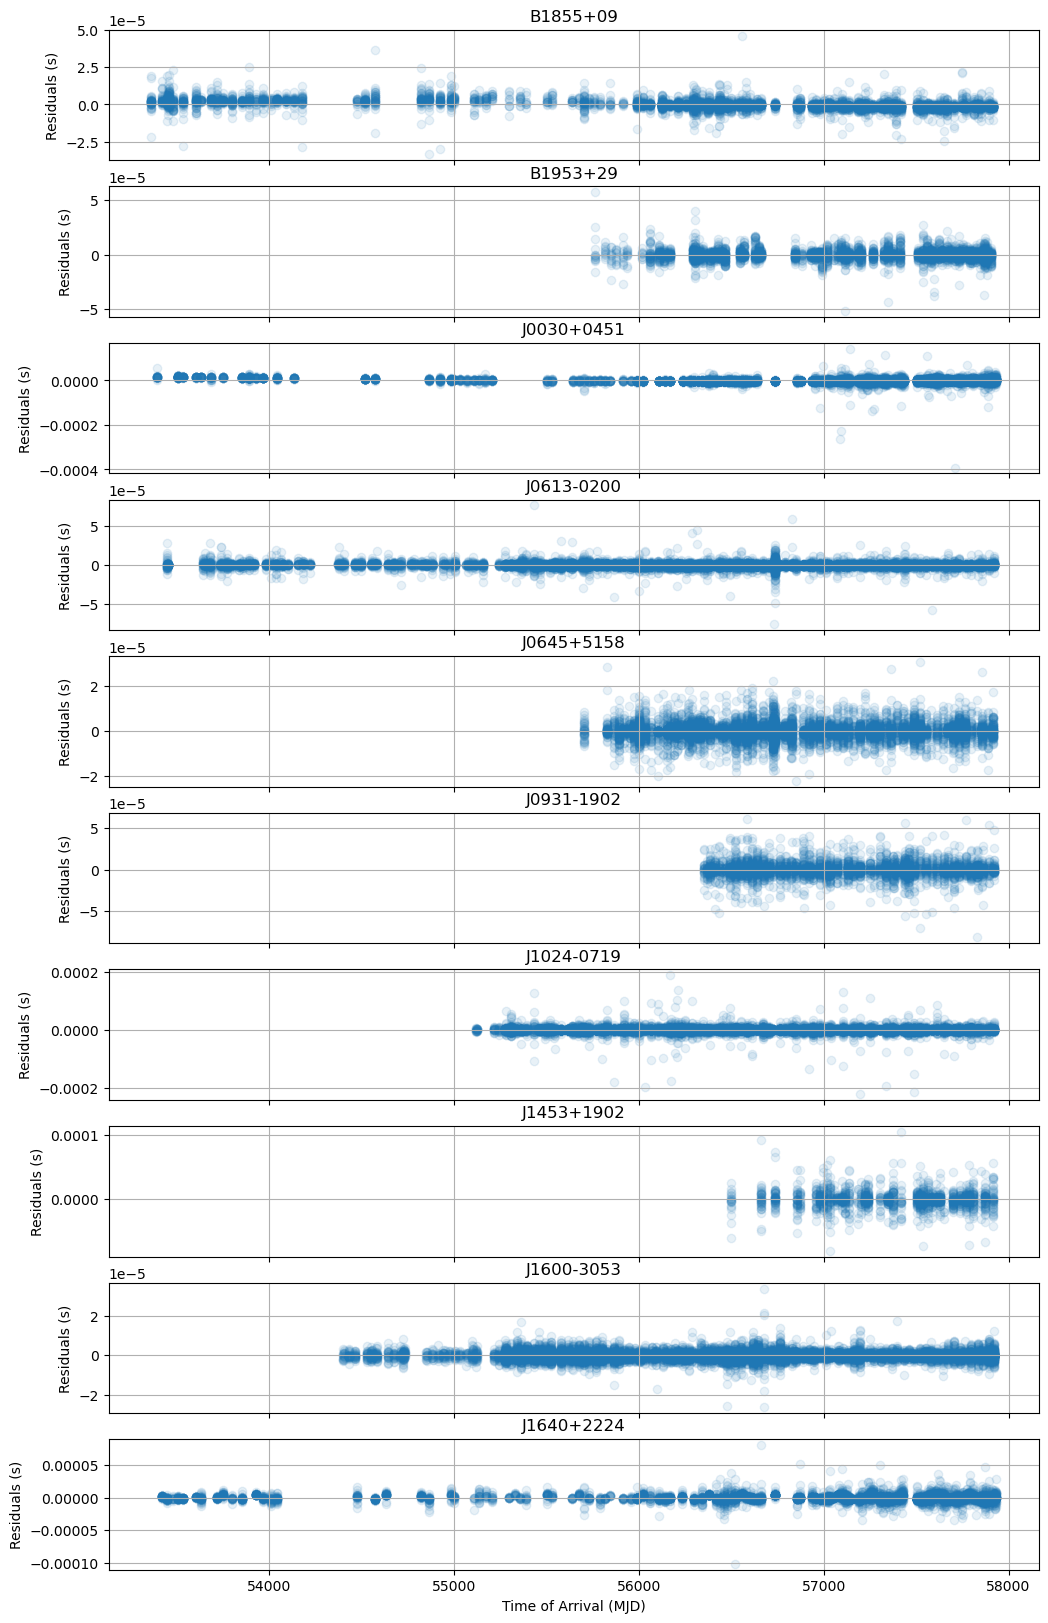

In [4]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(12, 20), sharex=True)
for ii in range(len(ax)):
    ax[ii].set_ylabel('Residuals (s)')
    ax[ii].set_title(psrs[ii * 2].name)
    ax[ii].scatter(psrs[ii * 2].toas / 86400, psrs[ii * 2].residuals, alpha=0.1)
    ax[-1].set_xlabel('Time of Arrival (MJD)')
    ax[ii].grid(visible=True)
plt.show()

* Here we have plotted the residuals for 10 different pulsars in the 12.5 year data set
* The total observation time span is different for each of the pulsars shown here
* Many of these pulsars have gaps in their data and are sampled unevenly
* For this reason, we work in the time domain when searching for gravitational waves.

* Next, we use `vars()` to print a dictionary of the attributes of a Pulsar object
* This should show us some of the data stored in the object

In [5]:
vars(psrs[0])

{'_sort': True,
 'planets': True,
 'name': 'B1855+09',
 '_toas': array([4.61019372e+09, 4.61019372e+09, 4.61019372e+09, ...,
        5.00388020e+09, 5.00388020e+09, 5.00388020e+09]),
 '_stoas': array([4.61019405e+09, 4.61019405e+09, 4.61019405e+09, ...,
        5.00387975e+09, 5.00387975e+09, 5.00387975e+09]),
 '_residuals': array([ 1.50490962e-06,  5.67110865e-07,  1.47881846e-06, ...,
        -2.95815515e-06, -1.58594102e-06, -1.33809972e-06]),
 '_toaerrs': array([3.820e-07, 6.070e-07, 2.156e-06, ..., 6.260e-07, 1.980e-07,
        3.040e-07]),
 '_designmatrix': array([[ 1.00000000e+00, -1.35100732e+02, -2.48066478e+02, ...,
          0.00000000e+00,  0.00000000e+00, -1.00000000e+00],
        [ 1.00000000e+00, -1.35100732e+02, -2.48066478e+02, ...,
          0.00000000e+00,  0.00000000e+00, -1.00000000e+00],
        [ 1.00000000e+00, -1.35100732e+02, -2.48066478e+02, ...,
          0.00000000e+00,  0.00000000e+00, -1.00000000e+00],
        ...,
        [ 1.00000000e+00,  1.89699710e+0

* The pulsar's name is under `name`
* We also find the residuals,
* TOA errors,
* timing model design matrix,
* DMX, a piecewise fit to the dispersion measure variations,
* among many other quantities.

We now turn to the noise dictionary to see what exists in the `channelized_12p5yr_v3_full_noisedict.json` file.

In [6]:
with open(datadir + '/channelized_12p5yr_v3_full_noisedict.json', 'r') as f:
    noisedict = json.load(f)

In [7]:
for key in noisedict.keys():
    if 'B1855+09' in key:
        print(key, '=', noisedict[key])

B1855+09_430_ASP_efac = 1.149036589204419
B1855+09_430_ASP_log10_ecorr = -7.415374510054153
B1855+09_430_ASP_log10_tnequad = -7.379759355541006
B1855+09_430_PUPPI_efac = 1.0543836580555548
B1855+09_430_PUPPI_log10_ecorr = -5.671108063699219
B1855+09_430_PUPPI_log10_tnequad = -6.348065001180634
B1855+09_L-wide_ASP_efac = 1.080749375878354
B1855+09_L-wide_ASP_log10_ecorr = -6.092899143243734
B1855+09_L-wide_ASP_log10_tnequad = -6.51289896375955
B1855+09_L-wide_PUPPI_efac = 1.2429537099744354
B1855+09_L-wide_PUPPI_log10_ecorr = -6.641281263572077
B1855+09_L-wide_PUPPI_log10_tnequad = -7.821737281350602
B1855+09_red_noise_gamma = 4.223680673175877
B1855+09_red_noise_log10_A = -14.029792598548077


* For example, we are showing the values for B1855+09, a single pulsar.
* This file contains median posterior values of white noise parameters.
* We use these in `enterprise` to reduce the number of parameters required in our Bayesian analysis from ~600 to ~90 (depending on the model we search with).

* In this tutorial we have briefly discussed some of the data files that NANOGrav uses in its search for an isotropic gravitational wave background.
* `.par` and `.tim` files are given to `enterprise` to instantiate a `Pulsar` object.
* The `Pulsar` class contains several pieces of information that `enterprise` needs to run.
* Analyses have been performed to create noise files which contain median posterior values of parameters resulting from those analyses.